<a href="https://colab.research.google.com/github/septgyurii/Parking_AI/blob/main/20250706_Smart_Parking_Lot_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ NumPy 다운그레이드
%pip install numpy==1.24.3 --force-reinstall

# ✅ 런타임 재시작 필수
import os
os.kill(os.getpid(), 9)

  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.5.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
xarray-einstats 0.9.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
pymc 5.23.0 requ

In [1]:
# YOLOv5와 가장 잘 맞는 PyTorch 2.1.0 설치
%pip install torch==2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import zipfile
import os
from google.colab import drive

# 1) Google Drive 마운트
drive.mount('/content/drive')

# 2) 압축 파일(.zip) 경로
zip_path = "/content/drive/MyDrive/Colab Notebooks/test_imgs.zip"

# 3) 압축 해제할 경로
extract_path = "/content/drive/MyDrive/Colab Notebooks"

# 4) .zip 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(path=extract_path)

print("✅ 압축 해제 완료:", extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 압축 해제 완료: /content/drive/MyDrive/Colab Notebooks


In [3]:
import tarfile
import os

from google.colab import drive
drive.mount('/content/drive')


tar_path = '/content/drive/MyDrive/Colab Notebooks/car_yolo.tar'
extract_dir = '/content/car_yolo_raw'

os.makedirs(extract_dir, exist_ok=True)
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_dir)

print("✅ 압축 해제 완료:", extract_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 압축 해제 완료: /content/car_yolo_raw


In [4]:
import shutil

yolo_base = "/content/car_yolo_yolov5"
img_src = os.path.join(extract_dir, "ds/img")
json_src = os.path.join(extract_dir, "ds/ann")

img_dst = os.path.join(yolo_base, "images/train")
label_dst = os.path.join(yolo_base, "labels/train")

os.makedirs(img_dst, exist_ok=True)
os.makedirs(label_dst, exist_ok=True)

# 이미지 복사
for fname in os.listdir(img_src):
    if fname.endswith(".png"):
        shutil.copy(os.path.join(img_src, fname), os.path.join(img_dst, fname))


In [5]:
import json

sample_json = os.path.join(json_src, os.listdir(json_src)[0])
with open(sample_json) as f:
    data = json.load(f)

print(json.dumps(data, indent=2))

{
  "description": "",
  "tags": [],
  "size": {
    "height": 300,
    "width": 400
  },
  "objects": [
    {
      "id": 6325301,
      "classId": 8709,
      "description": "",
      "geometryType": "rectangle",
      "labelerLogin": "az@datasetninja.com",
      "createdAt": "2023-06-13T22:38:53.151Z",
      "updatedAt": "2023-06-13T22:38:53.151Z",
      "tags": [],
      "classTitle": "license plate",
      "points": {
        "exterior": [
          [
            200,
            149
          ],
          [
            251,
            167
          ]
        ],
        "interior": []
      }
    }
  ]
}


In [6]:
import os
import json

json_dir = '/content/car_yolo_raw/ds/ann'
label_dir = '/content/car_yolo_yolov5/labels/train'
os.makedirs(label_dir, exist_ok=True)

def convert_json_to_yolo(json_path, output_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    img_width = data['size']['width']
    img_height = data['size']['height']

    yolo_lines = []

    for obj in data['objects']:
        if obj['classTitle'] != 'license plate':
            continue  # skip other classes if any

        # Bounding box corners
        (x_min, y_min), (x_max, y_max) = obj['points']['exterior']

        # YOLO format
        x_center = ((x_min + x_max) / 2) / img_width
        y_center = ((y_min + y_max) / 2) / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        line = f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        yolo_lines.append(line)

    # Save to .txt with same base filename
    txt_filename = os.path.basename(json_path).replace('.json', '.txt')
    txt_path = os.path.join(output_path, txt_filename)

    with open(txt_path, 'w') as f:
        f.write('\n'.join(yolo_lines))

# 전체 변환 실행
for fname in os.listdir(json_dir):
    if fname.endswith('.json'):
        convert_json_to_yolo(os.path.join(json_dir, fname), label_dir)

print("✅ YOLOv5 라벨(txt) 파일 생성 완료:", label_dir)


✅ YOLOv5 라벨(txt) 파일 생성 완료: /content/car_yolo_yolov5/labels/train


In [7]:
yaml_content = """
train: /content/car_yolo_yolov5/images/train
val: /content/car_yolo_yolov5/images/train

nc: 1
names: ['license plate']
"""

with open('/content/car_yolo_yolov5/data.yaml', 'w') as f:
    f.write(yaml_content)

print("✅ data.yaml 생성 완료!")

✅ data.yaml 생성 완료!


In [8]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17511, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17511 (delta 5), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17511/17511), 16.62 MiB | 17.49 MiB/s, done.
Resolving deltas: 100% (12000/12000), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.9 MB/s eta 0:00:00


In [9]:
# Colab에서 SummaryWriter 줄 주석 처리
!sed -i 's/self.tb = SummaryWriter(str(s))/# self.tb = SummaryWriter(str(s))/g' /content/yolov5/utils/loggers/__init__.py
# SummaryWriter import 라인 완전 주석 처리
!sed -i 's/from torch.utils.tensorboard import SummaryWriter/# from torch.utils.tensorboard import SummaryWriter/g' /content/yolov5/utils/loggers/__init__.py
# try 아래에 pass 문 추가
!sed -i '21a\    pass' /content/yolov5/utils/loggers/__init__.py


In [10]:
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 50 \
  --data /content/car_yolo_yolov5/data.yaml \
  --weights yolov5s.pt \
  --name plate_yolo_train \
  --exist-ok \
  --nosave \
  --noplots

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/content/car_yolo_yolov5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, noplots=True, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=

In [11]:
############################# 학습 완료(해외) , 테스트 시작 , 테스트 데이터 (국내) ##########

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# 예시: Drive에 저장된 테스트 이미지 폴더
drive_img_dir = "/content/drive/MyDrive/Colab Notebooks/test_imgs"

# 복사해서 content/ 아래에 만들기
!cp -r "$drive_img_dir" /content/test_imgs

In [16]:
import os

label_dir = "/content/car_yolo_yolov5/labels/train"

rename_count = 0

for fname in os.listdir(label_dir):
    if fname.endswith(".png.txt"):
        old_path = os.path.join(label_dir, fname)
        new_name = fname.replace(".png.txt", ".txt")
        new_path = os.path.join(label_dir, new_name)
        os.rename(old_path, new_path)
        rename_count += 1

print(f"✅ 이름 수정 완료: {rename_count}개 라벨 파일에서 '.png' 제거됨.")

✅ 이름 수정 완료: 433개 라벨 파일에서 '.png' 제거됨.


In [19]:
# 학습 + .pt 파일 저장용
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 50 \
  --data /content/car_yolo_yolov5/data.yaml \
  --weights yolov5s.pt \
  --name plate_yolo_train \
  --exist-ok \
  --noplots  # nosave 제거 완료 .pt 파일 저장


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/content/car_yolo_yolov5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=True, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=plate_yolo_train, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interv

In [20]:
import shutil

src = "runs/train/plate_yolo_train/weights/best.pt"
dst = "/content/drive/MyDrive/Colab Notebooks/best.pt"

shutil.copy(src, dst)
print("✅ YOLO 모델이 Google Drive에 저장되었습니다:", dst)


✅ YOLO 모델이 Google Drive에 저장되었습니다: /content/drive/MyDrive/Colab Notebooks/best.pt


📊 Final Validation Metrics:
metrics/precision       0.95631
metrics/recall          0.98938
metrics/mAP_0.5         0.98563
metrics/mAP_0.5:0.95    0.74879
Name: 49, dtype: float64

📌 F1 Score: 0.9726


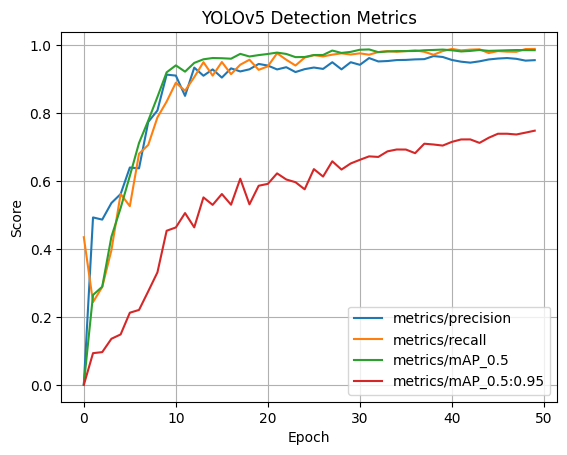

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/yolov5/runs/train/plate_yolo_train/results.csv')
df.columns = df.columns.str.strip()  # 공백 제거


# 마지막 에폭 값 추출
final_metrics = df.iloc[-1][['metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']]
print("📊 Final Validation Metrics:")
print(final_metrics)

# F1 Score 계산
precision = final_metrics['metrics/precision']
recall = final_metrics['metrics/recall']
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"\n📌 F1 Score: {f1_score:.4f}")

# 원하는 컬럼만 시각화
df[['metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']].plot()
plt.title("YOLOv5 Detection Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [22]:
#버전 확인 코드-------------------------------------------------------

import sys
import pkg_resources

# Python
print("Python:", sys.version.replace("\n", " "))

# 패키지 리스트
packages = [
    "numpy",
    "torch",
    "torchvision",
    "torchaudio",
    "opencv-python",
    "Pillow",
    "easyocr",
    "jax",
    "jaxlib",
    "tensorboard",
    "tensorflow",
]

for pkg in packages:
    try:
        v = pkg_resources.get_distribution(pkg).version
    except pkg_resources.DistributionNotFound:
        v = "Not installed"
    print(f"{pkg}: {v}")

# CUDA 사용 가능 여부 및 디바이스 정보 (PyTorch 기준)
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
numpy: 1.24.3
torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
torchaudio: 2.1.0+cu118
opencv-python: 4.11.0.86
Pillow: 11.2.1
easyocr: Not installed
jax: 0.5.2
jaxlib: 0.5.1
tensorboard: 2.18.0
tensorflow: 2.18.0
CUDA available: True
CUDA device: Tesla T4


In [ ]:
## .png 삭제해서 라벨이랑 이미지 파일 이름 맞췄음
''' import os

label_dir = "/content/car_yolo_yolov5/labels/train"

rename_count = 0

for fname in os.listdir(label_dir):
    if fname.endswith(".png.txt"):
        old_path = os.path.join(label_dir, fname)
        new_name = fname.replace(".png.txt", ".txt")
        new_path = os.path.join(label_dir, new_name)
        os.rename(old_path, new_path)
        rename_count += 1

print(f"✅ 이름 수정 완료: {rename_count}개 라벨 파일에서 '.png' 제거됨.")
 '''

In [ ]:
# 잘 되었는지 확인
''' img_files = sorted([f[:-4] for f in os.listdir("/content/car_yolo_yolov5/images/train")])
label_files = sorted([f[:-4] for f in os.listdir("/content/car_yolo_yolov5/labels/train")])

missing_labels = [f for f in img_files if f not in label_files]
print("❌ 라벨 없는 이미지 수:", len(missing_labels)) '''


In [ ]:
# TensorBoard, TensorFlow, JAX 모두 언인스톨
%pip uninstall -y tensorboard tensorflow jax jaxlib

# 확인용으로 한 번 더 tensorboard가 남아 있는지 체크
%pip show tensorboard
